<B> This assignment is submitted by KDD Project Group 3 : 
    <br>Bharadwaj Aryasomayajula<br>Akhil Morampudi<br>
    Mahanth Mukesh Dadisetty<br>Ramachandra Gopal Sanjith Posina <br>Dinesh Deshi<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
pd.options.display.max_columns = None
import missingno as msno
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE

<b>import the dataset

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

<b>Run the first 5 columns

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<b>Checking for missing values using msno library

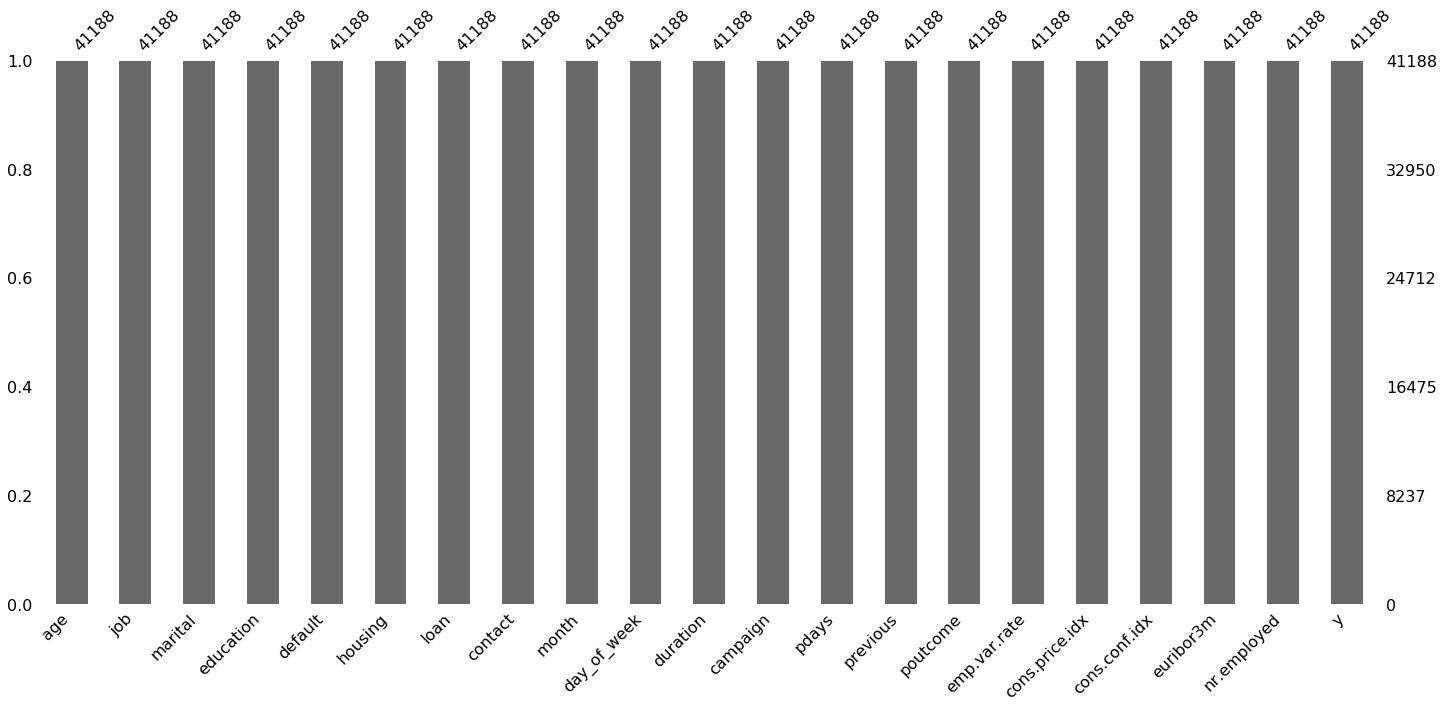

In [4]:
# Checking for missing values.

msno.bar(df)

<b>Split the predictor and target variables into X and y variables respectively

In [5]:
# Split into predictor and response dataframes.

X_df = df.drop('y', axis=1)
y = df['y']

X_df.shape,y.shape

((41188, 20), (41188,))

<b>Map "yes" and "no" to 1 and 0 respectively

In [6]:
# Map response variable to integers 0,1.
y = pd.Series(np.where(y.values == 'yes',1,0), y.index)
y.value_counts()

0    36548
1     4640
dtype: int64

In [7]:
# Label encode categorical variables.

label_encoder = LabelEncoder()
mappings = []

# Desired label orders for categorical columns.

educ_order = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

# using cat.codes for order, one hot for high cardinality and weak case of cardinality.

def ordered_labels(df, col, order):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)

# Use dummy variables for occupation
X_df = pd.concat([X_df, pd.get_dummies(X_df['job'])],axis=1).drop('job',axis=1)

# Use ordered cat.codes for days, months, and education
ordered_labels(X_df, 'education', educ_order)
ordered_labels(X_df, 'month', month_order)
ordered_labels(X_df, 'day_of_week', day_order)

# Same label encoding for rest since low cardinality
for i, col in enumerate(X_df):
    if X_df[col].dtype == 'object':
        X_df[col] = label_encoder.fit_transform(np.array(X_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

X_df.head()

,age,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
0,56,1,2,0,0,0,1,2,0,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0
1,57,1,5,1,0,0,1,2,0,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0
2,37,1,5,0,2,0,1,2,0,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0
3,40,1,3,0,0,0,1,2,0,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0
4,56,1,5,0,0,2,1,2,0,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0


<b>Split the dataset into train and test categories

In [8]:
# Split feature and label sets to train and data sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 31), (8238, 31), (32950,), (8238,))

<b>Normalize using the MinMaxScaler

In [9]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<b>Creating Pipeline for the dataset before applying SMOTE<br>

In [10]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.6min finished


<b>Predicting the test data before sampling using SMOTE

In [13]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<b>Check the accuracy of the classifier before using SMOTE<br>

In [14]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.9104151493080845


<b>Draw ROC Curve <b>

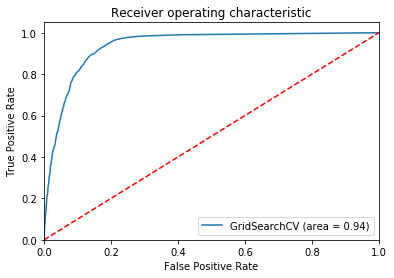

In [15]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<b>Check the roc_auc score<b>

In [16]:
roc_auc

0.9376672396103591

<b>Check the accuracy,balanced_accuracy,precision,average_precision,f1_score,recall,roc_auc scores before using SMOTE

In [17]:
classes = best_clf.predict(X_test)
    
accuracy = metrics.accuracy_score(classes, y_test)
    
balanced_accuracy = metrics.balanced_accuracy_score(classes, y_test)

precision = metrics.precision_score(classes, y_test)
    
average_precision = metrics.average_precision_score(classes, y_test)
    
f1_score = metrics.f1_score(classes, y_test)
    
recall = metrics.recall_score(classes, y_test)

print (accuracy, balanced_accuracy, precision, average_precision, f1_score, recall, roc_auc)

0.9104151493080845 0.786945106345424 0.4709051724137931 0.33083908795935846 0.5421836228287841 0.6388888888888888 0.9376672396103591


<b>Checking the classification report

In [19]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      7554
           1       0.47      0.64      0.54       684

    accuracy                           0.91      8238
   macro avg       0.72      0.79      0.75      8238
weighted avg       0.93      0.91      0.92      8238



<b>Applying SMOTE<b><br>
SMOTE is an over-sampling method. What it does is, it creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class.

<b>Resample the X_train and y_train data using SMOTE and fit the resampled data to the classifier

In [21]:
# Rerunning above with resampled data
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
best_clf = clf.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 34.3min finished


<b>Predicting test dataset after resampling

In [22]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<b>Accuracy for resampled dataset.We can observe that the accuracy score is reduced after using SMOTE because the classes are evenly divided and the model is not biased.

<b>SMOTE - Synthetic Minority Over-sampling Technique </b>

In [23]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.9088370963826171


<b>Check the ROC curve after resampling. We can observe the difference in the curve after using SMOTE.

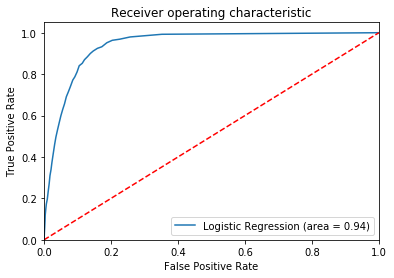

In [24]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<b>Check the Classification report after applying SMOTE. The model performs accurately after resampling

In [25]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      7554
           1       0.47      0.64      0.54       684

    accuracy                           0.91      8238
   macro avg       0.72      0.79      0.75      8238
weighted avg       0.93      0.91      0.92      8238

